In [1]:
import numpy as np
import networkx as nx
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

from scipy.spatial.distance import cdist, pdist, squareform

import Voronoi
from shapely.geometry import LineString

import os
import sys

WEST_ROOT = os.environ['WEST_ROOT']
for lib in ['lib/wwmgr', 'src', 'lib/west_tools']:
    path = os.path.join(WEST_ROOT, lib)
    if path not in sys.path:
        sys.path.append(path)

%matplotlib inline

In [2]:
import west

# h5py storage types
vstr_dtype = h5py.new_vlen(str)
idtype = np.dtype([('iter_name', vstr_dtype), ('string_index', np.int32)])

In [3]:
## Potential Data
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)

X,Y = np.meshgrid(x,y)

alpha = 3.0
gamma  = 3.0
chi1 = 2.25
chi2 = 4.5
r = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y,X)
V = alpha*(r - gamma)**2 - chi1*np.cos(2*theta) - chi2*np.cos(4*theta)
V -= np.min(V)

clines = np.arange(18)
my_cmap = cm.get_cmap('RdYlBu_r')

In [4]:
# Bin data
mappers = []
mapper_dict = {}


data_manager = west.rc.get_data_manager()
data_manager.open_backing(mode='r')

# Get each mapper stored in the unique bin_mapper objects
string_hashes = data_manager.we_h5file['bin_topologies']['index'][:]['hash']
n_strings = string_hashes.size

for si, shash in enumerate(string_hashes):
    bin_mapper = data_manager.get_bin_mapper(shash)
    mappers.append(bin_mapper)
    
# Get per iteration mapper
iterations = data_manager.we_h5file['iterations'].keys()
n_iters = len(iterations)

for iiter, iter_name in enumerate(iterations):
    if iiter % 100 == 0:
        print 'Processing {} of {}'.format(iiter, n_iters)

    try:
        iter_group = data_manager.we_h5file['iterations'][iter_name]
        if 'binhash' in iter_group.attrs:
            binhash = iter_group.attrs['binhash']
            string_index = data_manager.find_bin_mapper(binhash)
        else:
            string_index = -1
    except:
        print 'Error in processing iteration {}'.format(iter_name)
        print sys.exc_info()
        break
        
    mapper_dict[iter_name] = string_index


data_manager.close_backing()

Processing 0 of 201
Processing 100 of 201
Processing 200 of 201


In [5]:
def plot_voronoi_orig(ax, points, lw, color):

    PL = []
    for p in points:
        PL.append(Voronoi.Site(x=p[0],y=p[1]))

    v,eqn,edges,wtf = Voronoi.computeVoronoiDiagram(PL)

    edge_points=[]
    for (l,x1,x2) in edges:
        if x1>=0 and x2>=0:
            edge_points.append((v[x1],v[x2]))

    lines = LineCollection(edge_points, linewidths=lw, color=color)
    
    ax.add_collection(lines)

    return edge_points

In [6]:
def compute_voronoi_lines(points):
    PL = []
    for p in points:
        PL.append(Voronoi.Site(x=p[0],y=p[1]))

    v,eqn,edges,wtf = Voronoi.computeVoronoiDiagram(PL)

    edge_points=[]
    for (l,x1,x2) in edges:
        if x1>=0 and x2>=0:
            edge_points.append((v[x1],v[x2]))

    return edge_points
    
def get_centers(mapper, node_ix):
    _centers = mapper.fetch_centers(node_ix)
    ncenters = _centers.shape[0]

    # Add bounding points
    centers = np.empty((ncenters + 4, 2), np.float32)
    centers[4:,:] = _centers

    sf = 50
    xmin, ymin = np.min(_centers, axis=0) - sf
    xmax, ymax = sf + np.max(_centers, axis=0)
    centers[0,:] = [xmin, ymin]
    centers[1,:] = [xmin, ymax]
    centers[2,:] = [xmax, ymin]
    centers[3,:] = [xmax, ymax]
    
    return centers
    
def plot_voronoi(ax, mapper):
    lw = [4, 2, 0.7]
    color = ['k', 'k', 'k']
    delta = 0.1
    G = mapper.bin_graph
    parent_lines = []
    for li, level_ix in enumerate(mapper.level_indices[:-1]):
        centers = get_centers(mapper, level_ix)
        edge_points = compute_voronoi_lines(centers)
         
        if li == 0:
            lines = LineCollection(edge_points, linewidths=lw[li], color=color[0])
            ax.add_collection(lines)
            for ep in edge_points:
                parent_lines.append(LineString(ep))
        
        #ax.plot(centers[:,0], centers[:,1], '.', color=color[li], ms=8*lw[li])
        
        for k, nix in enumerate(level_ix):
            c = centers[k + 4]
            
            
            successors = nx.DiGraph.successors(G, nix)
            succ_centers = get_centers(mapper, successors)
            succ_edge_points = compute_voronoi_lines(succ_centers)
            
            #lines = LineCollection(succ_edge_points, linewidths=lw[li+1], color=color[li+1])
            #ax.add_collection(lines)
            #ax.plot(succ_centers[:,0], succ_centers[:,1], '.', color=color[li+1], ms=8*lw[li+1])
            
            new_edge_points = []
            
            # Determine the closest point that a successor edge
            # crosses a parent edge
            for sep in succ_edge_points:
                # if both end points are closer to another center, skip
                pp = np.array([[sep[0][0], sep[0][1]], [sep[1][0], sep[1][1]]])
                d = cdist(pp, centers[4:])
                mdc1, mdc2 = np.argmin(d, axis=1)
                if mdc1 != k and mdc2 != k:
                    continue
                
                
                line_succ = LineString(sep)
                intersection_points = []
                for line_parent in parent_lines:
                    ip = line_succ.intersection(line_parent)
                    if not ip.is_empty:
                        #print '----'
                        #print line_succ
                        #print ip
                        #print line_parent
                        #print '----'
                        if not ip == line_succ:
                            intersection_points.append([ip.x, ip.y])
                    
                # Determine successor edge point that's closest to parent center
                # and still in the cell
                d1 = d[0,k]  #(sep[0][0] - c[0])**2 + (sep[0][1] - c[1])**2
                d2 = d[1,k]  #(sep[1][0] - c[0])**2 + (sep[1][1] - c[1])**2
                
                if d1 < d2 and mdc1 == k:
                    p1 = sep[0]
                    indx = 0
                else:
                    p1 = sep[1]
                    indx = 1
                
                # Determine closest intersection point to p1
                if len(intersection_points):
                    d = cdist(np.array([p1]), np.array(intersection_points))
                    p2 = intersection_points[np.argmin(d)]
                else:
                    p2 = sep[1] if indx == 0 else sep[0]
                
                
                new_edge_points.append((p1, p2))
                #parent_lines.append(LineString((p1,p2)))
                
            slines = LineCollection(new_edge_points, linewidths=lw[li+1], color=color[li+1])
            ax.add_collection(slines)
            for ep in new_edge_points:
                parent_lines.append(LineString(ep))
                
            

(-5, 5)

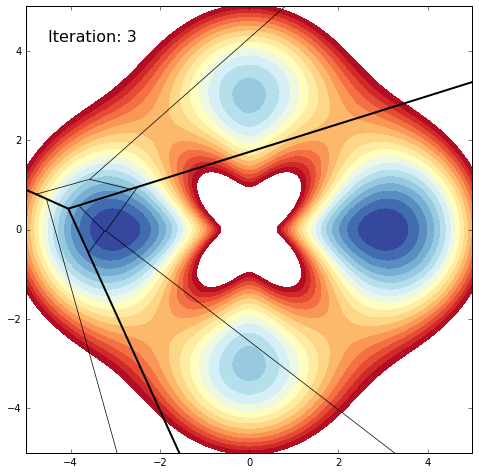

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
m = mappers[2]
plot_voronoi(ax, m)
ax.contourf(X, Y, V, clines, cmap=my_cmap)
ax.text(0.05, 0.95, 'Iteration: {}'.format(3),
        horizontalalignment='left',
        verticalalignment='top',
        fontsize=16,
        transform=ax.transAxes)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

Iteration: 2
Iteration: 5
Iteration: 10
Iteration: 20
Iteration: 25
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 199


/Users/alexrd/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


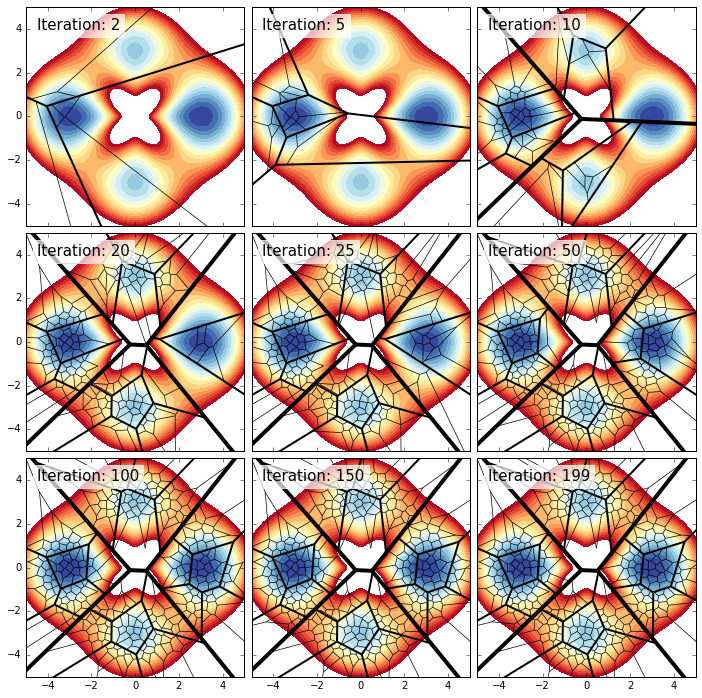

In [8]:
fig = plt.figure(figsize=(12,12))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (3, 3), # creates 2x2 grid of axes
                axes_pad=0.1, # pad between axes in inch.
                )

for ii, niter in enumerate([2, 5,10, 20, 25, 50, 100, 150, 199]):
    print 'Iteration: {}'.format(niter)
    ax = grid[ii]
    m = mappers[niter]
    plot_voronoi(ax, m)
    ax.contourf(X, Y, V, clines, cmap=my_cmap)
    t = ax.text(0.05, 0.95, 'Iteration: {}'.format(niter),
        horizontalalignment='left',
        verticalalignment='top',
        fontsize=15,
        transform=ax.transAxes)
    t.set_bbox(dict(color='white', alpha=0.7, edgecolor='white'))
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    
plt.savefig('binspace.png')

/Users/alexrd/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


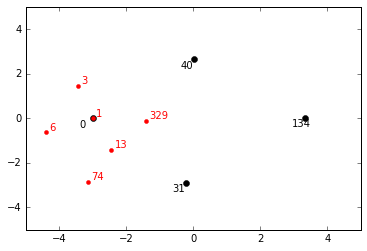

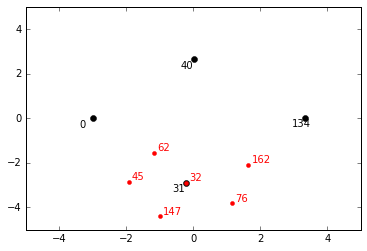

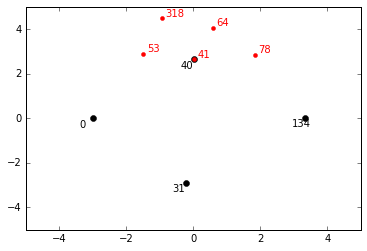

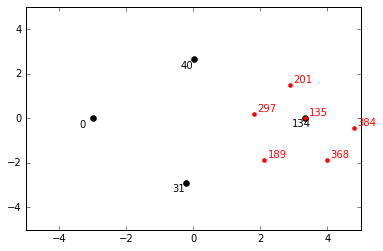

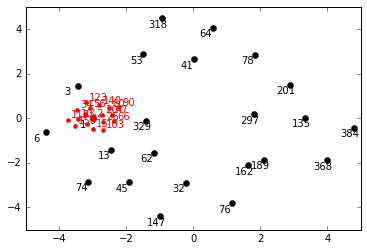

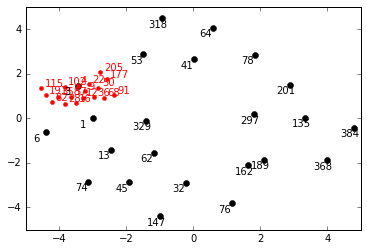

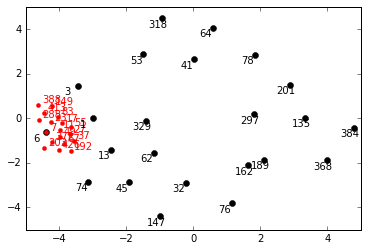

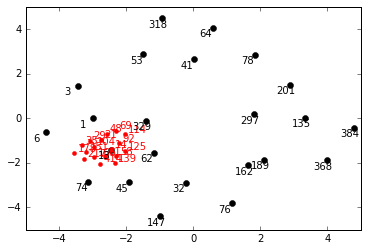

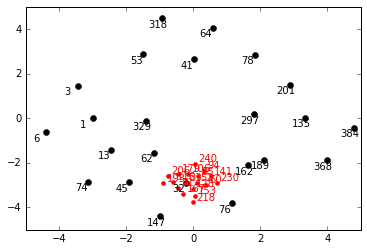

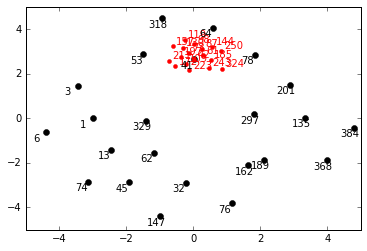

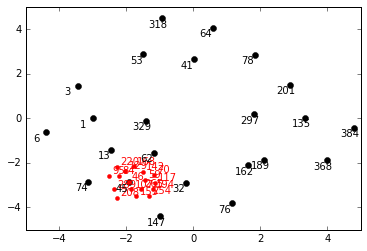

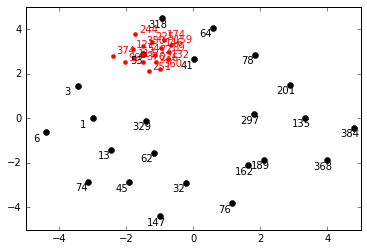

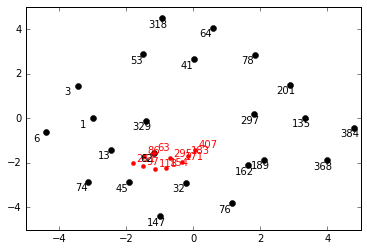

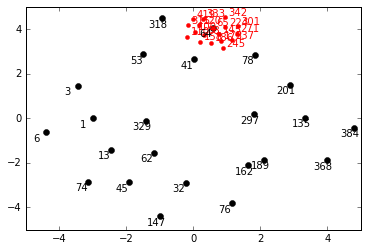

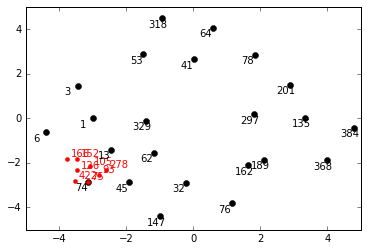

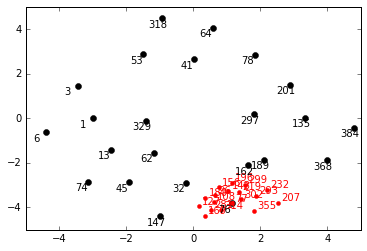

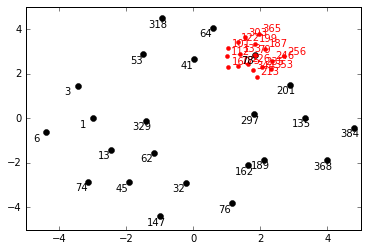

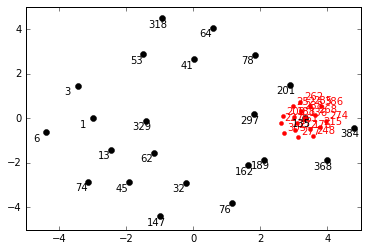

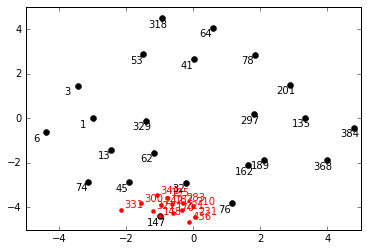

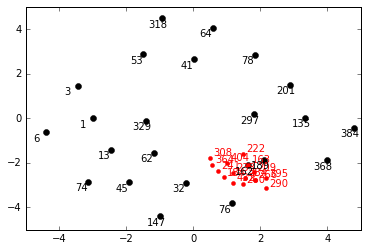

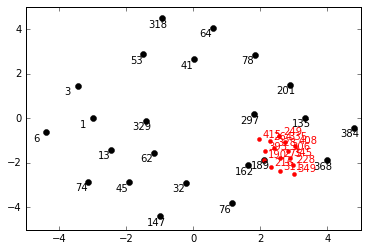

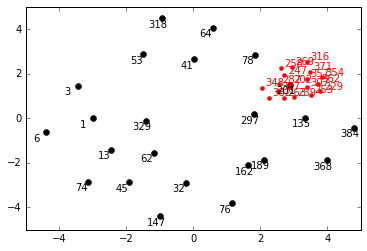

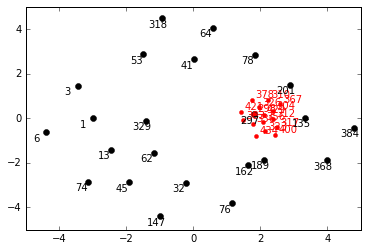

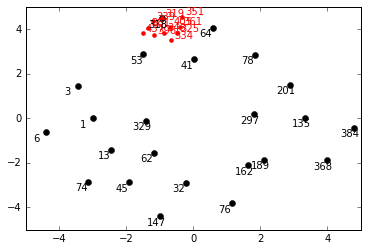

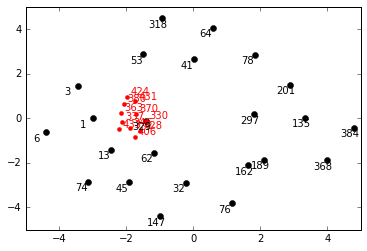

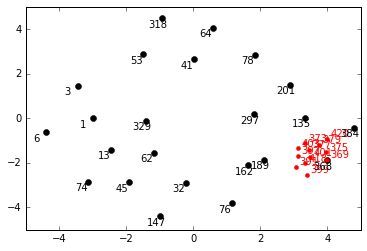

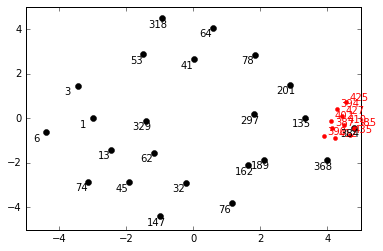

In [9]:
m = mappers[-1]
G = m.bin_graph
for li, level_ix in enumerate(m.level_indices[:-1]):
    centers = get_centers(m, level_ix)[4:]
    for k, nix in enumerate(level_ix):
        successors = G.successors(nix)
        succ_centers = get_centers(m, successors)[4:]
        
        d = cdist(succ_centers, centers)
        
        plt.figure()
        plt.plot(centers[:,0], centers[:,1], 'k.', ms=12)
        plt.plot(succ_centers[:,0], succ_centers[:,1], 'r.', ms=8)
        plt.xlim(-5,5)
        plt.ylim(-5,5)
        
        for ii, si in enumerate(successors):
            x = succ_centers[ii,0]
            y = succ_centers[ii,1]
            
            plt.annotate(si, (x,y), (x + 0.1, y + 0.1), color='r')
            
        for ii, si in enumerate(level_ix):
            x = centers[ii,0]
            y = centers[ii,1]
            
            plt.annotate(si, (x,y), (x - 0.4, y - 0.4), color='k')
        



In [121]:
len(mappers)

200